# Movie Recommendeation with Content-Based and collaborative Filtering

An example of recommendation system is such as this:
- User A watches Game of Thrones and Breaking Bad.
- User B does search on Game of Thrones, then the system suggests Breaking Bad from data collected about user A.

Two most ubiquitous types of personalized recommendation systems are **Content-Based** and **Collaborative Filtering**. Collaborative filtering produces recommendations based on the knowledge of users’ attitude to items, that is it uses the “wisdom of the crowd” to recommend items. In contrast, content-based recommendation systems focus on the attributes of the items and give you recommendations based on the **similarity between them**.

## The MoviesLens Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ratings = pd.read_csv('ratings.csv',encoding='latin-1',usecols=['user_id','movie_id','rating'])

users = pd.read_csv('users.csv',encoding='latin-1',usecols=['user_id','gender','zipcode','age_desc','occ_desc'])

movies = pd.read_csv('movies.csv',encoding='latin-1',usecols=['movie_id','title','genres'])

## Ratings Dataset

In [2]:
print(ratings.head())

   user_id  movie_id  rating
0        1      1193       5
1        1       661       3
2        1       914       3
3        1      3408       4
4        1      2355       5


In [3]:
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
user_id     1000209 non-null int64
movie_id    1000209 non-null int64
rating      1000209 non-null int64
dtypes: int64(3)
memory usage: 22.9 MB
None


## Users Dataset

In [4]:
print(users.head())

   user_id gender zipcode  age_desc              occ_desc
0        1      F   48067  Under 18          K-12 student
1        2      M   70072       56+         self-employed
2        3      M   55117     25-34             scientist
3        4      M   02460     45-49  executive/managerial
4        5      M   55455     25-34                writer


In [5]:
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
user_id     6040 non-null int64
gender      6040 non-null object
zipcode     6040 non-null object
age_desc    6040 non-null object
occ_desc    6040 non-null object
dtypes: int64(1), object(4)
memory usage: 236.0+ KB
None


## Movies Dataset

In [6]:
print(movies.head())

   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy


In [7]:
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
movie_id    3883 non-null int64
title       3883 non-null object
genres      3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
None


## Data Exploration

In [8]:
%matplotlib inline
import wordcloud
from wordcloud import WordCloud,STOPWORDS

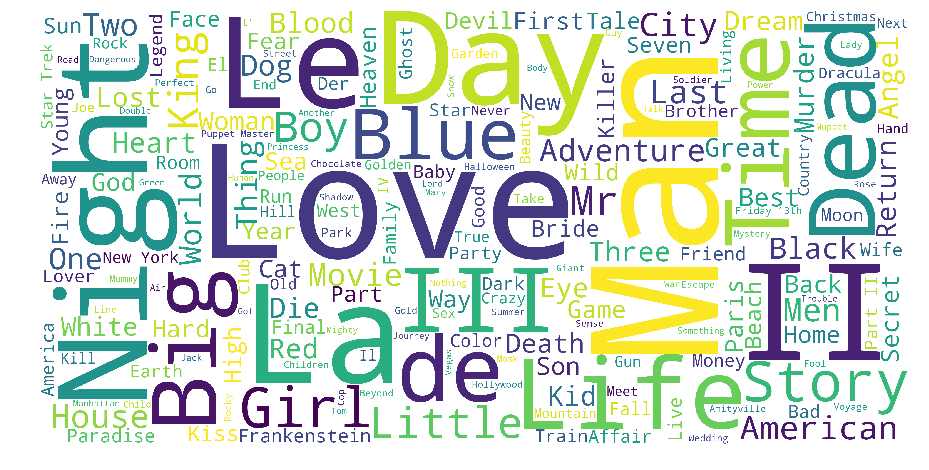

In [9]:
movies['title'] = movies['title'].fillna('').astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS,
                            background_color='white',
                            height=2000,
                            width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

## Ratings

In [10]:
ratings['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

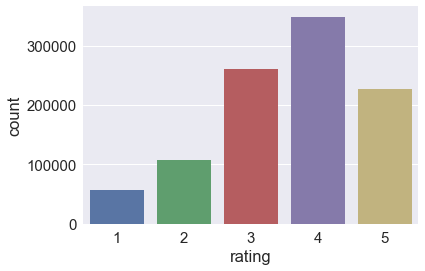

In [11]:
import seaborn as sns
sns.set(font_scale=1.5)
sns.countplot(ratings['rating'].fillna(ratings['rating'].median()))
plt.show()

In [12]:
dataset = pd.merge(pd.merge(movies,ratings,on='movie_id'),users,on='user_id')
dataset[['title','genres','rating']].sort_values('rating',ascending=False).head(20)

,title,genres,rating
0,Toy Story (1995),Animation|Children's|Comedy,5
489283,American Beauty (1999),Comedy|Drama,5
489259,Election (1999),Comedy,5
489257,"Matrix, The (1999)",Action|Sci-Fi|Thriller,5
489256,Dead Ringers (1988),Drama|Thriller,5
489237,Rushmore (1998),Comedy,5
489236,"Simple Plan, A (1998)",Crime|Thriller,5
489226,Hands on a Hard Body (1996),Documentary,5
489224,Pleasantville (1998),Comedy,5
489212,Say Anything... (1989),Comedy|Drama|Romance,5


## Genres

In [13]:
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))
print(genre_labels)

{'Animation', 'Thriller', 'Film-Noir', 'Action', 'War', 'Western', 'Crime', 'Comedy', 'Documentary', 'Sci-Fi', 'Drama', "Children's", 'Adventure', 'Romance', 'Fantasy', 'Musical', 'Mystery', 'Horror'}


In [14]:
def count_word(dataset,ref_col,census):
    keyword_count = dict()
    for s in census:
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):
        if type(census_keywords) == float and pd.isnull(census_keywords):
            continue
        for s in [s for s in census_keywords if s in census]:
            if pd.notnull(s):
                keyword_count[s] += 1
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key= lambda x: x[1],reverse=True)
    return keyword_occurences,keyword_count

In [15]:
keyword_occurences, dum = count_word(movies,'genres',genre_labels)
keyword_occurences[:5]

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471]]

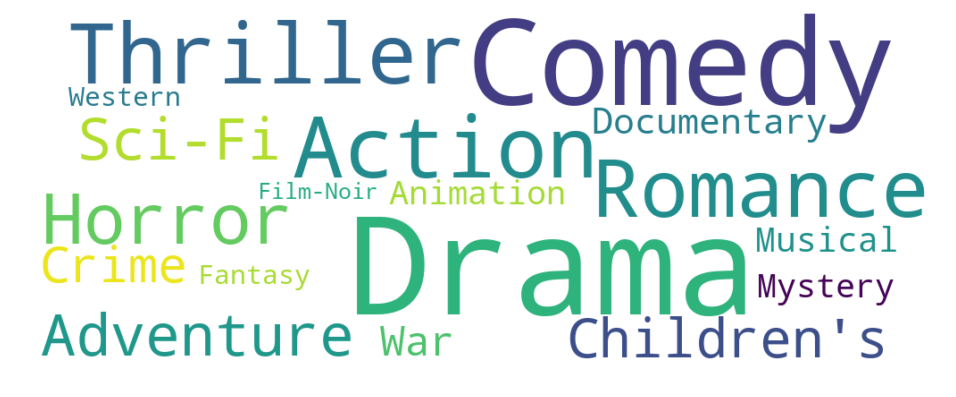

In [16]:
genres  = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

genre_wordcloud = WordCloud(width=1000,height=400,background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

f,ax = plt.subplots(figsize=(16,8))
plt.imshow(genre_wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Types of Recommendation Engines

### 1.Content-Based

The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it's easy to determine the context/properties of each item.

A content based recommender works with data that the user provides, either explicitly movie ratings for the MovieLens dataset. Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

### 2. Collaborative Filtering

The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context. More specifically, it is based on the similarity in preferences, tastes and choices of two users. It analyses how similar the tastes of one user is to another and makes recommendations on the basis of that.

For instance, if user A likes movies 1, 2, 3 and user B likes movies 2,3,4, then they have similar interests and A should like movie 4 and B should like movie 1. This makes it one of the most commonly used algorithm as it is not dependent on any additional information.

In general, collaborative filtering is the workhorse of recommender engines. The algorithm has a very interesting property of being able to do feature learning on its own, which means that it can start to learn for itself what features to use. It can be divided into Memory-Based Collaborative Filtering and Model-Based Collaborative filtering. In this post, I'll only focus on the Memory-Based Collaborative Filtering technique.

### Content-Based Recommendation Model

The **concepts of Term Frequency (TF)** and **Inverse Document Frequency (IDF)** are used in information retrieval systems and also content based filtering mechanisms (such as a content based recommender). They are used to determine the relative importance of a document / article / news item / movie etc.

TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents. TF-IDF is used mainly because of two reasons: Suppose we search for **“the results of latest European Socccer games”** on Google. It is certain that **“the”** will occur more frequently than **“soccer games”** but the relative importance of **soccer games** is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

Below is the equation to calculate the TF-IDF score:
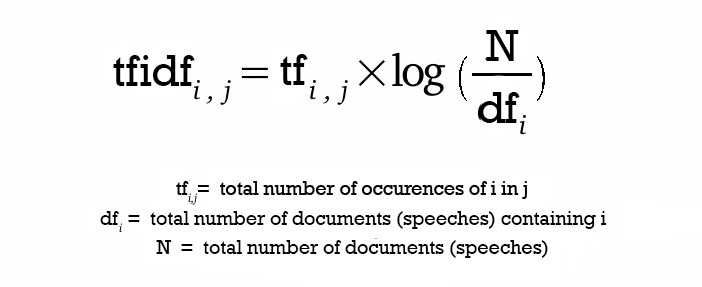

After calculating TF-IDF scores, how do we determine which items are closer to each other, rather closer to the user profile? This is accomplished using the **Vector Space Model** which computes the proximity based on the angle between the vectors. In this model, each item is stored as a vector of its attributes (which are also vectors) in an **n-dimensional space** and the angles between the vectors are calculated to **determine the similarity between the vectors**. Next, the user profile vectors are also created based on his actions on previous attributes of items and the similarity between an item and a user is also determined in a similar way.

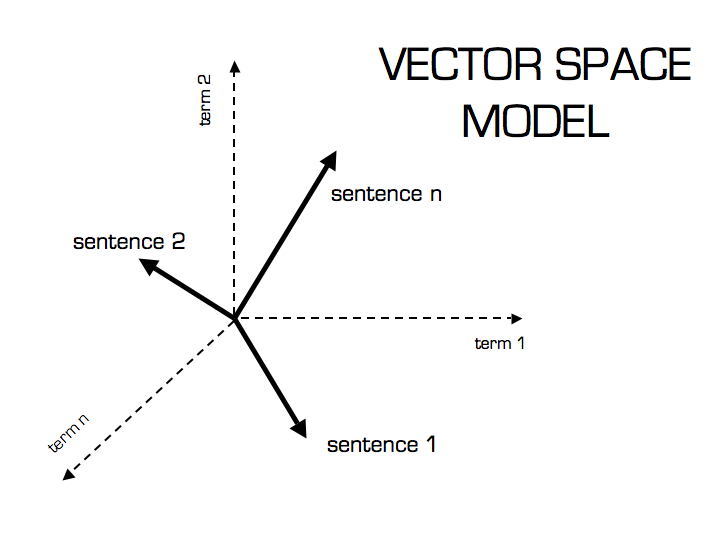

Sentence 2 is more likely to be using Term 2 than using Term 1. Vice-versa for Sentence 1. The method of calculating this relative measure is calculated by taking the cosine of the angle between the sentences and the terms. The ultimate reason behind using cosine is that the **value of cosine will increase with decreasing value of the angle** between which signifies more similarity. The vectors are length normalized after which they become vectors of length 1 and then the cosine calculation is simply the sum-product of vectors.

### implementation

In [17]:
movies['genres'] = movies['genres'].str.split('|')
movies['genres'] = movies['genres'].fillna('').astype('str')

In [18]:
print(movies['genres'].head())

0     ['Animation', "Children's", 'Comedy']
1    ['Adventure', "Children's", 'Fantasy']
2                     ['Comedy', 'Romance']
3                       ['Comedy', 'Drama']
4                                ['Comedy']
Name: genres, dtype: object


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1,2),min_df=0,stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

(3883, 127)

In [20]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)
cosine_sim[:4,:4]

array([[1.        , 0.14193614, 0.09010857, 0.1056164 ],
       [0.14193614, 1.        , 0.        , 0.        ],
       [0.09010857, 0.        , 1.        , 0.1719888 ],
       [0.1056164 , 0.        , 0.1719888 , 1.        ]])

In [21]:
titles = movies['title']
indices = pd.Series(movies.index,index=movies['title'])

In [22]:
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores,key=lambda x: x[1],reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [23]:
genre_recommendations('Good Will Hunting (1997)').head(20)

25                                        Othello (1995)
26                                   Now and Then (1995)
29     Shanghai Triad (Yao a yao yao dao waipo qiao) ...
30                                Dangerous Minds (1995)
35                               Dead Man Walking (1995)
39                       Cry, the Beloved Country (1995)
42                                    Restoration (1995)
52                                       Lamerica (1994)
54                                        Georgia (1995)
56                          Home for the Holidays (1995)
61                             Mr. Holland's Opus (1995)
66                                       Two Bits (1995)
77                            Crossing Guard, The (1995)
79          White Balloon, The (Badkonake Sefid ) (1995)
81                       Antonia's Line (Antonia) (1995)
82       Once Upon a Time... When We Were Colored (1995)
89                    Journey of August King, The (1995)
92                             

In [24]:
genre_recommendations('Saving Private Ryan (1998)').head(20)

461            Heaven & Earth (1993)
1204        Full Metal Jacket (1987)
1214     Boat, The (Das Boot) (1981)
1222                    Glory (1989)
1545                G.I. Jane (1997)
1959      Saving Private Ryan (1998)
2358       Thin Red Line, The (1998)
2993         Longest Day, The (1962)
3559            Flying Tigers (1942)
3574    Fighting Seabees, The (1944)
3585    Guns of Navarone, The (1961)
3684             Patriot, The (2000)
40                Richard III (1995)
153            Beyond Rangoon (1995)
332         Walking Dead, The (1995)
523          Schindler's List (1993)
641        Courage Under Fire (1996)
967          Nothing Personal (1995)
979           Michael Collins (1996)
1074                  Platoon (1986)
Name: title, dtype: object

## Collaborative Filtering Recommendation Model

### Theory

There are 2 main types of memory-based collaborative filtering algorithms:

- **1.User-User Callaborative Filtering:**Here we find look alike users based on similarity and recommend movies which first user's look-alike has chosen in past. This algorithm is very effective but takes a lot of time and resources. It requires to compute every user pair information which takes time. Therefore, for big base platforms, this algorithm is hard to implement without a very strong parallelizable system.

- **2.Item-Item Collaborative Filtering:**It is quite similar to previous algorithm, but instead of finding user's look-alike, we try finding movie's look-alike. Once we have movie's look-alike matrix, we can easily recommend alike movies to user who have rated any movie from the dataset. This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new user, the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between users. And with fixed number of movies, movie-movie look alike matrix is fixed over time. 

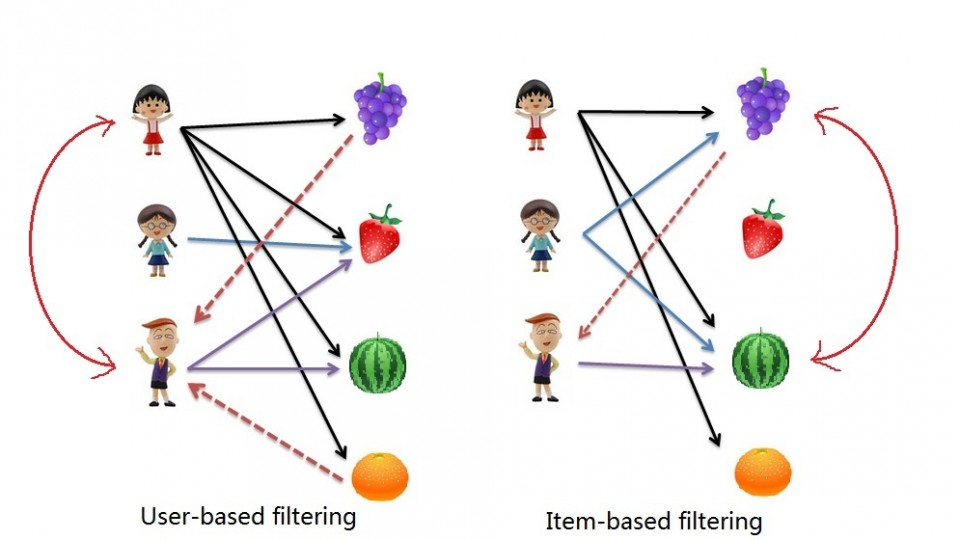

In either scenario, we builds a similarity matrix. For user-user collaborative filtering, the user-similarity matrix will consist of some distance metrics that measure the similarity between any two pairs of users. Likewise, the item-similarity matrix will measure the similarity between any two pairs of items.

There are 3 distance similarity metrics that are usually used in collaborative filtering:

**1.Jaccard Similarity:**

- Similarity is based on the number of users which have rated item A and B divided by the number of users who have rated either A or B
- It is typically used where we don’t have a numeric rating but just a boolean value like a product being bought or an add being clicked

**2.Cosine Similarity: (as in the Content-Based system)**

- Similarity is the cosine of the angle between the 2 vectors of the item vectors of A and B
- Closer the vectors, smaller will be the angle and larger the cosine

**3.Pearson Similarity**

- Similarity is the pearson coefficient between the two vectors.

### Implementation

In [25]:
ratings['user_id'] = ratings['user_id'].fillna(0)
ratings['movie_id'] = ratings['movie_id'].fillna(0)
ratings['rating'] = ratings['rating'].fillna(ratings['rating'].mean())

In [26]:
small_data = ratings.sample(frac=0.02)
print(small_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20004 entries, 825351 to 143994
Data columns (total 3 columns):
user_id     20004 non-null int64
movie_id    20004 non-null int64
rating      20004 non-null int64
dtypes: int64(3)
memory usage: 625.1 KB
None


In [27]:
from sklearn.model_selection import train_test_split

train_data,test_data = train_test_split(small_data,test_size=0.2)

In [28]:
train_data_matrix = train_data[['user_id','movie_id','rating']].values
test_data_matrix = test_data[['user_id','movie_id','rating']].values

print(train_data_matrix.shape)
print(test_data_matrix.shape)

(16003, 3)
(4001, 3)


In [29]:
from sklearn.metrics.pairwise import pairwise_distances


user_correlation = 1 - pairwise_distances(train_data_matrix, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation[:4, :4])

[[ 1.          0.83162043  0.59277817  0.54960786]
 [ 0.83162043  1.          0.04571103 -0.00688227]
 [ 0.59277817  0.04571103  1.          0.99861645]
 [ 0.54960786 -0.00688227  0.99861645  1.        ]]


In [30]:
item_correlation = 1 - pairwise_distances(train_data_matrix.T,metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0 
print(item_correlation[:4,:4])

[[ 1.         -0.01122331  0.01085405]
 [-0.01122331  1.         -0.07646624]
 [ 0.01085405 -0.07646624  1.        ]]


In [31]:
def predict(ratings, similarity,type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_user_rating[:,np.newaxis])
        pred = mean_user_rating[:,np.newaxis] + similarity.dot(ratings_diff)/np.array([np.abs(similarity).sum(axis=1)])
    elif type == 'item':
        pred = ratings.dot(similarity)/np.array([np.abs(similarity).sum(axis=1)])
    return pred